# Chapter 6

## Preamble

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import os
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
plt.style.use("seaborn-dark")
plt.rcParams["figure.figsize"] = (15, round(15 / np.sqrt(2)))

## Exercises 6E1, 6E2, 6E3

In [3]:
def H(*ps):
    ps_ = np.array(ps)
    return np.sum(-ps_ * np.log(ps_))

In [4]:
print(f"Exercise 6E1: {H(0.7, 0.3):.2f}")
print(f"Exercise 6E2: {H(0.2, 0.25, 0.25, 0.30):.2f}")
print(f"Exercise 6E3: {H(1/3, 1/3, 1/3):.2f}")

Exercise 6E1: 0.61
Exercise 6E2: 1.38
Exercise 6E3: 1.10


## Intermezzo: Getting started with pymc3

In [5]:
θ_ = 0.35
data = np.where(np.random.uniform(size=4) < θ_, 1, 0)

In [6]:
with pm.Model() as model:
    θ = pm.Beta("θ", alpha=1., beta=1.)
    y = pm.Bernoulli("y", p=θ, observed=data)
    trace = pm.sample(1000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 5641.89draws/s]


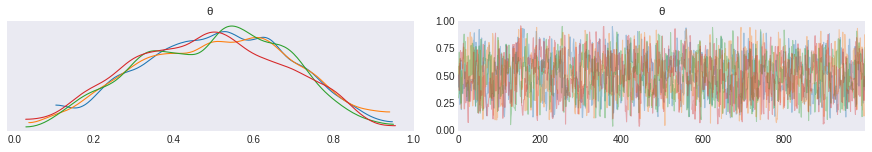

In [7]:
az.plot_trace(trace);

## Exercises 6H1, 6H2, 6H3, 6H4, 6H5, 6H6

### Setup

In [8]:
DATA_PATH = "../external/rethinking/data/Howell1.csv"
df = pd.read_csv(DATA_PATH, sep=";")
train, test = train_test_split(df, test_size=0.5)
print(f"Number of samples in training set {len(train)}")
print(f"Number of samples in test set {len(test)}")
display(train.head())

Number of samples in training set 272
Number of samples in test set 272


,height,weight,age,male
444,147.32,48.959587,25.0,0
63,161.29,52.219779,31.0,1
43,147.32,39.122310,42.0,0
352,157.48,47.570461,43.0,1
466,55.88,4.847764,0.0,0


In [9]:
def design_matrix(ws, n):
    return np.repeat([ws], n, axis=0).transpose() ** range(1, n + 1)

def model(ws, hs, *, n, σ_β=10):
    W = design_matrix(ws, n)
    model = pm.Model()
    with model:
        α = pm.Normal("α", mu=175, sd=10)
        β = pm.Normal("β", mu=0, sd=σ_β, shape=n)
        σ = pm.HalfNormal("σ", 10)
        μ = α + pm.math.dot(W, β)
        h = pm.Normal("h", mu=μ, sd=σ, observed=hs)
    return model

def normalize(ws):
    def fn(xs):
        return (xs - np.mean(ws)) / np.std(ws)
    return fn

ws = normalize(train.age.values)(train.age.values)
hs = train.height.values
N = 6
models = [model(ws, hs, n=i) for i in range(1, N + 1)]
models.append(model(ws, hs, n=6, σ_β=5))

In [10]:
def save_traces(traces):
    for (i, trace) in enumerate(traces):
        directory = f".cache/6h/model-{i}" 
        os.makedirs(directory, exist_ok=True)
        pm.backends.text.dump(directory, trace=trace)
        
def load_traces(models):
    result = []
    for (i, model) in enumerate(models):
        directory = f".cache/6h/model-{i}"
        if os.path.exists(directory):
             result.append(pm.backends.text.load(directory, model))
    return result

traces = [] # load_traces(models) 
# Always recompute traces, since computing the WAIC from the stored trace does not work somehow.
_recompute_traces = True

estimates = []
for (i, model) in enumerate(models):
    
    if _recompute_traces:
        traces.append(pm.sample(draws=8000, tune=2000, model=model, chains=4))
    estimates.append(pm.find_MAP(model=model))
if _recompute_traces:
    save_traces(traces)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:08<00:00, 4578.21draws/s]
logp = -1,231.3, ||grad|| = 5.3791: 100%|██████████| 27/27 [00:00<00:00, 3253.73it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:10<00:00, 3937.10draws/s]
logp = -1,090.7, ||grad|| = 2.1294: 100%|██████████| 40/40 [00:00<00:00, 2925.82it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:15<00:00, 2539.39draws/s]
logp = -994.44, ||grad|| = 2.5028: 100%|██████████| 51/51 [00:00<00:00, 3173.17it/s]   
Auto-assigning NUTS sampler...
Initializing NUTS usi

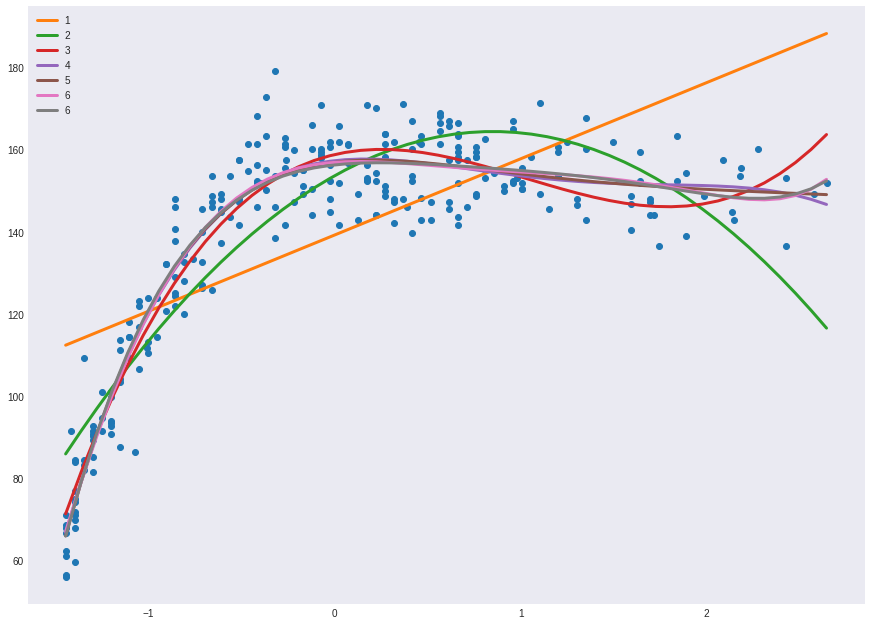

In [11]:
def plot_estimate(ws, estimate, **kwargs):
    xs = np.linspace(np.min(ws), np.max(ws))
    W = design_matrix(xs, len(estimate["β"]))
    ys = estimate["α"] + np.dot(W, estimate["β"])
    plt.plot(xs, ys, label=f"{len(estimate['β'])}", **kwargs)
    
plt.plot(ws, hs, "o");
for estimate in estimates:
    plot_estimate(ws, estimate, linewidth=3) 
plt.legend();

### Exercise 6H1 

In [12]:
## TODO: Interesting error message about the posterior variance of the log predictive densities being too large.
waics = [az.waic(trace) for trace in traces] 
measures = pd.DataFrame({"waic": [w.waic for w in waics],
                         "p_waic": [w.p_waic for w in waics]})
measures["waic_"] = np.max(measures.waic) - measures.waic
display(measures)

/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1208: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,waic,p_waic,waic_
0,-1215.267021,3.565686,250.590416
1,-1075.844921,5.280587,111.168316
2,-979.102674,5.449221,14.426070
3,-964.676605,5.719344,0.000000
4,-965.340007,6.336099,0.663402
5,-964.914295,7.194964,0.237690
6,-965.764252,6.669186,1.087647


### Exercise 6H2

In [13]:
def plot_from_sample(xs, yss, ax, p=0.95, label=None, **kwargs):
    μ = np.mean(yss, axis=1) 
    σ = np.sqrt(np.mean(yss ** 2, axis=1) - μ ** 2) 
    z = st.norm.ppf((1 - p) / 2)
    ax.plot(xs, μ, color="black", linewidth=1, **kwargs)
    # Compute the confidence intervals based on a normal approximation
    # to the predictive posterior distribution at the grid points
    ax.fill_between(xs, μ - z * σ, μ + z * σ, label=label, alpha=0.5)
    
def sample_curve(xs, trace, n=1000):
    xs = np.linspace(np.min(ws), np.max(ws))
    W = design_matrix(xs, len(trace["β"][0]))
    indices = np.random.choice(range(len(trace["α"])), size=n)
    αs = trace["α"][indices]
    βs = trace["β"][indices].transpose()
    return αs + np.dot(W, βs)  

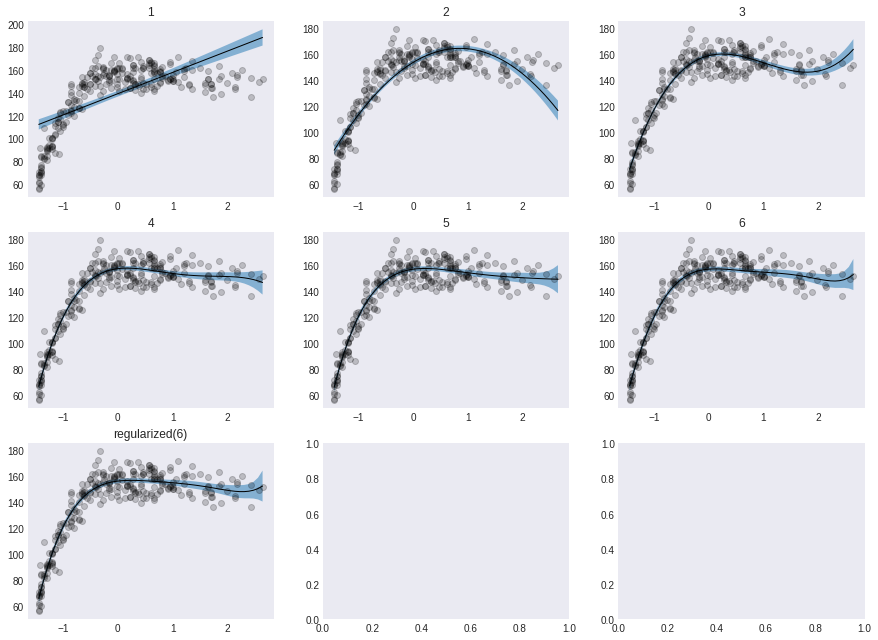

In [14]:
fig, ax = plt.subplots(3, 3) 
xs = np.linspace(np.min(ws), np.max(ws))
for (i, trace) in enumerate(traces):
    ax[i // 3, i % 3].plot(ws, hs, "o", color="black", alpha=0.2)
    label = i + 1 if i < 6 else "regularized(6)"
    ax[i // 3, i % 3].set_title(label)
    yss = sample_curve(xs, trace, n=10000)
    plot_from_sample(xs, yss, ax=ax[i // 3, i % 3], label=label) 
plt.show()

### Exercise 6H3

In [15]:
def aikake_weights(measures):
    # See page 199 of McElreath
    ϵ = np.exp(0.5 * measures.waic.values)
    return ϵ / np.sum(ϵ)

def sample_mixture(xs, traces, ps, n=10000):
    counts = np.random.multinomial(n, pvals=ps)
    samples = []
    for (trace, count) in zip(traces, counts):
        samples.append(sample_curve(xs, trace, count))
    return np.hstack(samples)

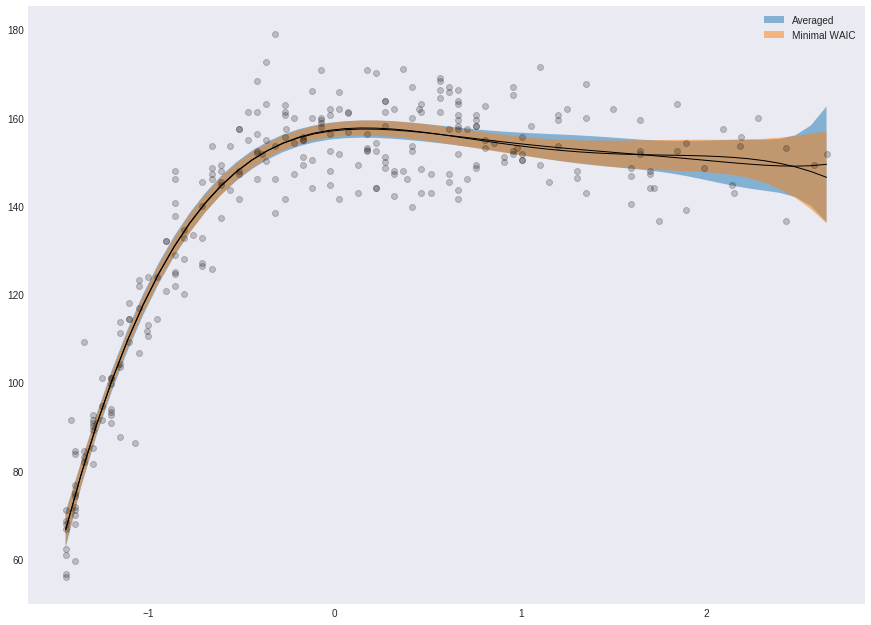

In [16]:
ps = aikake_weights(measures.iloc[:6])
yss = sample_mixture(xs, traces[:6], ps)
fig, ax = plt.subplots() 
ax.plot(ws, hs, "o", color="black", alpha=0.2)
plot_from_sample(xs, yss, ax, p=0.97, label="Averaged")

yss = sample_curve(xs, traces[3])
plot_from_sample(xs, yss, ax, p=0.97, label="Minimal WAIC")

ax.legend();

### Exercise 6H4

In [17]:
def deviance(estimate, xs, ys):
    W = design_matrix(xs, len(estimate["β"]))
    μs = estimate["α"] + np.dot(W, estimate["β"])
    return -2 * np.sum(np.log(st.norm.pdf(ys, loc=μs, scale=estimate["σ"])))

In [18]:
deviances = []
for estimate in estimates:
    xs = normalize(train.age.values)(test.age.values) 
    deviances.append(deviance(estimate, xs, test.height.values))
measures["deviance.test"] = deviances

deviances = []
for estimate in estimates:
    xs = normalize(train.age.values)(train.age.values) 
    deviances.append(deviance(estimate, xs, train.height.values))
measures["deviance.train"] = deviances
 
measures["deviance.test_"] = measures["deviance.test"] - np.min(measures["deviance.test"])
measures["deviance.train_"] = measures["deviance.train"] - np.min(measures["deviance.train"])
display(measures)

,waic,p_waic,waic_,deviance.test,deviance.train,deviance.test_,deviance.train_
0,-1215.267021,3.565686,250.590416,2387.667520,2423.865773,513.405818,509.481972
1,-1075.844921,5.280587,111.168316,2139.909472,2142.151391,265.647770,227.767590
2,-979.102674,5.449221,14.426070,1923.774163,1947.457152,49.512461,33.073352
3,-964.676605,5.719344,0.000000,1874.955110,1917.356488,0.693409,2.972688
4,-965.340007,6.336099,0.663402,1874.261702,1917.129129,0.000000,2.745329
5,-964.914295,7.194964,0.237690,1876.361435,1914.383800,2.099733,0.000000
6,-965.764252,6.669186,1.087647,1878.042388,1917.037490,3.780686,2.653689


## Intermezzo: Computing the design matrix

In [20]:
def design_matrix(ws, n):
    return np.repeat([ws], n, axis=0).transpose() ** range(1, n + 1)

def design_matrix_(ws, n):
    result = np.zeros((len(ws), n))
    for i in range(1, n + 1):
        result[:, i - 1] = ws ** i
    return result

def design_matrix__(ws, n):
    return ws.reshape((-1, 1)) ** np.arange(1, n + 1).reshape((1, -1))

n = 10000
ws = np.array(list(range(0, 10000)))
%time x = design_matrix(ws, n)
%time x = design_matrix_(ws, n)
%time x = design_matrix__(ws, n)

CPU times: user 946 ms, sys: 104 ms, total: 1.05 s
Wall time: 1.05 s
CPU times: user 1.77 s, sys: 144 ms, total: 1.92 s
Wall time: 1.92 s
CPU times: user 4.24 s, sys: 69.4 ms, total: 4.31 s
Wall time: 4.31 s
